# Analytic continuation of a matrix Green's function with known spectrum: solution to exercise

In [ ]:
import OmegaMaxEnt_TRIQS as OT
from math import ceil, exp, sqrt, pi, cos, sin
from pytriqs.dos import HilbertTransform, DOSFromFunction  #to compute G from A
from pytriqs.gf import *
import numpy as np
from matplotlib import pyplot as plt  #to plot the result
import os
import shutil as su

First, let us create the working directory: 

In [2]:
output_dir = 'output_MaxEnt'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
os.chdir(output_dir)

We start by defining the means, standard deviations and weights of the peaks:

In [3]:
mw1 = [-2, 0, 1]
sd1 = [1, 0.2, 0.5]
wgt1 = [1,1,1]
Wgts1 = sum(wgt1)
Npks1 = len(mw1)
mw2 = [-1, 1.5]
sd2 = [0.3, 0.7]
wgt2 = [1,1]
Wgts2 = sum(wgt2)
Npks2 = len(mw2)
wmin = -10
wmax = 10

Then we define the spectral function for the two spectra:

In [5]:
def spectr_val1(w):
    v = 0
    for i in range(0,Npks1):
        v = v+(wgt1[i]/sd1[i])*exp(-(w-mw1[i])*(w-mw1[i])/(2*sd1[i]*sd1[i]))
    return v/(Wgts1*sqrt(2*pi))

def spectr_val2(w):
    v = 0
    for i in range(0,Npks2):
        v = v+(wgt2[i]/sd2[i])*exp(-(w-mw2[i])*(w-mw2[i])/(2*sd2[i]*sd2[i]))
    return v/(Wgts2*sqrt(2*pi))

and define DOSFromFunction objects for those spectra:

In [6]:
Dw = min(sd1+sd2)/10
Npts = int((wmax-wmin)/Dw+1)
d1 = DOSFromFunction(spectr_val1, wmin, wmax, Npts)
d2 = DOSFromFunction(spectr_val2, wmin, wmax, Npts)

The parameters of the Matsubara grid:

In [7]:
beta = 50
wnmax = 30
n_freq = int(ceil(beta*wnmax/(2*pi)))

Then we define the $2\times 2$ diagonal Matsubara Green's functions:

In [ ]:
G = GfImFreq(indices=[0,1], beta=beta, n_points=n_freq)
Gtmp = GfImFreq(indices=[0], beta=beta, n_points=n_freq)
Sigma0 = GfImFreq(indices=[0], beta=beta, n_points=n_freq) 
Sigma0.zero()
Gtmp << HilbertTransform(d1)(Sigma=Sigma0)
G[0,0] = Gtmp[0,0]
Gtmp << HilbertTransform(d2)(Sigma=Sigma0)
G[1,1] = Gtmp[0,0]

Now we define the rotation matrix:

In [9]:
theta = pi/8
R = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])

and we rotate the matrix Green's function:

In [10]:
G_rot = GfImFreq(indices=[0,1], beta=beta, n_points=n_freq)
G_rot.from_L_G_R(R, G, R.transpose())

Now, we add noise:

In [11]:
err = 1e-4
G_rot.data.real = G_rot.data.real+err*np.reshape(np.random.randn(np.size(G_rot.data.real)),np.shape(G_rot.data.real))
G_rot.data.imag = G_rot.data.imag+err*np.reshape(np.random.randn(np.size(G_rot.data.real)),np.shape(G_rot.data.real))

and we call *compute_GfReFreq()*:

In [12]:
GR = OT.compute_GfReFreq(G_rot, interactive_mode=False, inv_sym=True)

G[0,0] computed
G[1,1] computed
G[0,1] computed
continuation done


Note that we have set *inv_sym=True* because the spectral functions $A_{ij}(\omega)$ are real, which implies, from the definition $A_{ij}(\omega)=i\left[G_{ij}^R(\omega)-\left(G_{ji}^R(\omega)\right)^*\right]/(2\pi)$, that $A_{ji}=A_{ij}$ ($A_{ji}=A_{ij}^*$ in general), hence, $G_{ji}=G_{ij}$.

Then, we define a real frequency grid and vectors for the exact spectrum:

In [13]:
w = np.arange(-5,5,0.01)
Aw = np.zeros((2,2,len(w)))
Aw[0,0,:] = np.array([spectr_val1(wi) for wi in w])
Aw[1,1,:] = np.array([spectr_val2(wi) for wi in w])

for i in range(len(w)):
    Aw[:,:,i] = np.dot(R,np.dot(Aw[:,:,i],R.transpose()))

and define the output spectra:

In [14]:
AG = 1j*(GR-GR.transpose().conjugate())/(2*pi)
w_out = np.array([v.value for v in GR.mesh])
A_out = np.zeros((2,2,len(w_out)))
A_out[0,0,:] = AG[0,0].data.real
A_out[0,1,:] = AG[0,1].data.real
A_out[1,0,:] = A_out[0,1,:]
A_out[1,1,:] = AG[1,1].data.real

Note that we also have *Aij_out=-GR[i,j].data.imag/pi* here because $A_{ji}=A_{ij}$.

We can now plot the results:

In [15]:
%matplotlib inline

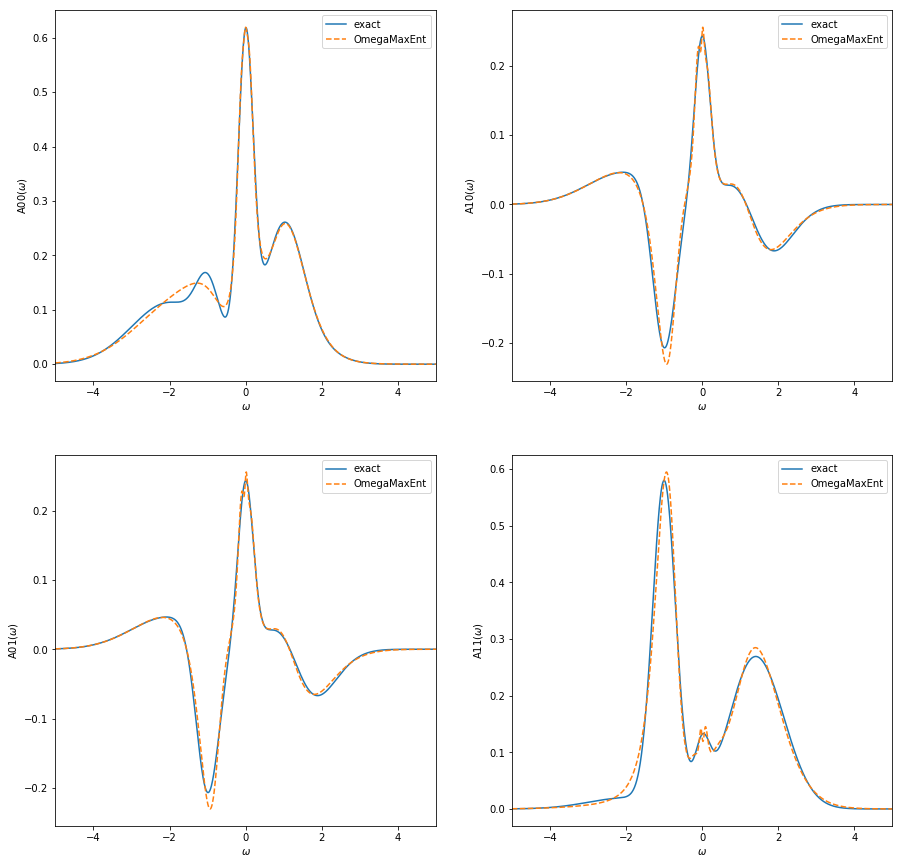

In [16]:
plt.rcParams['figure.figsize'] = [15, 15]

plt.figure()
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,i+2*j+1)
        plt.plot(w, Aw[i,j,:], label='exact')
        plt.plot(w_out,A_out[i,j,:], label='OmegaMaxEnt', ls='--')
        plt.xlim([-5,5])
        plt.xlabel(r'$\omega$')
        plt.ylabel('A'+str(i)+str(j) +'($\omega$)')
        plt.legend()

In [17]:
os.chdir("..")
su.rmtree(output_dir)